# Exploration and classification of dynamical regimes

wrt. weights of ecosystem and trade income

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns

## run 01

_first full run_

SETTING|VALUE
-|-
jobid | 28845801
parameter combinations | 44 x 44
samples | 30
tasks | 58080
nodes | 4
tasks-per-node | 15
array-jobs | 484
computation time per job | h ~ 04:40:00  
`precip_modulation` | `False`

~ 60 h total computation time, could probably be improved by specifiying `#SBATCH --time=05:00:00`

In [ ]:
# parameter combinations
r_trades = np.arange(5000, 9400, 100).tolist()
r_ess = np.arange(0.05, 0.16, 0.0025).round(decimals=4).tolist()

In [ ]:
data = pd.read_pickle('/p/tmp/fritzku/MayaSim/output/x11_dynamical_regimes_03/results/ensemble_means.pkl')

data = data.droplevel('test')

In [ ]:
r_trades = [round(x, 5) for x in np.arange(5000, 9400, 800)]
r_ess = [round(x, 4) for x in np.arange(0.02, 0.13, 0.02)]

fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess))
fig.set_figwidth(6*len(r_ess))
fig.set_figheight(4*len(r_trades))

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    # plot mean
    pop_mean = data.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_mean>']
    pop_mean.plot(ax=ax[j,i], legend=False, color='black', label=f'r_es = {r_es}, r_trade = {r_trade}')

    # plot sigma
    pop_sigma = data.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_sigma>']
    ax[j,i].fill_between(pop_mean.index, pop_mean + pop_sigma, pop_mean - pop_sigma, color='black', alpha=.2)

    ax[j,i].legend()

### all aggregate trajectories

In [9]:
#r_trades = np.arange(5000, 9400, 100).tolist()
#r_ess = np.arange(0.05, 0.16, 0.0025).round(decimals=4).tolist()

r_trades = [5000, 6100, 7200, 8300, 9300]
r_ess = [0.05, 0.07, 0.09, 0.11, 0.13]

# load data
path = '/p/tmp/fritzku/MayaSim/output/x11_dynamical_regimes/results/all_trjs.hd5'
with pd.HDFStore(path) as store:
    df = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess}', columns=['total_population'])
    df = df.droplevel('test')

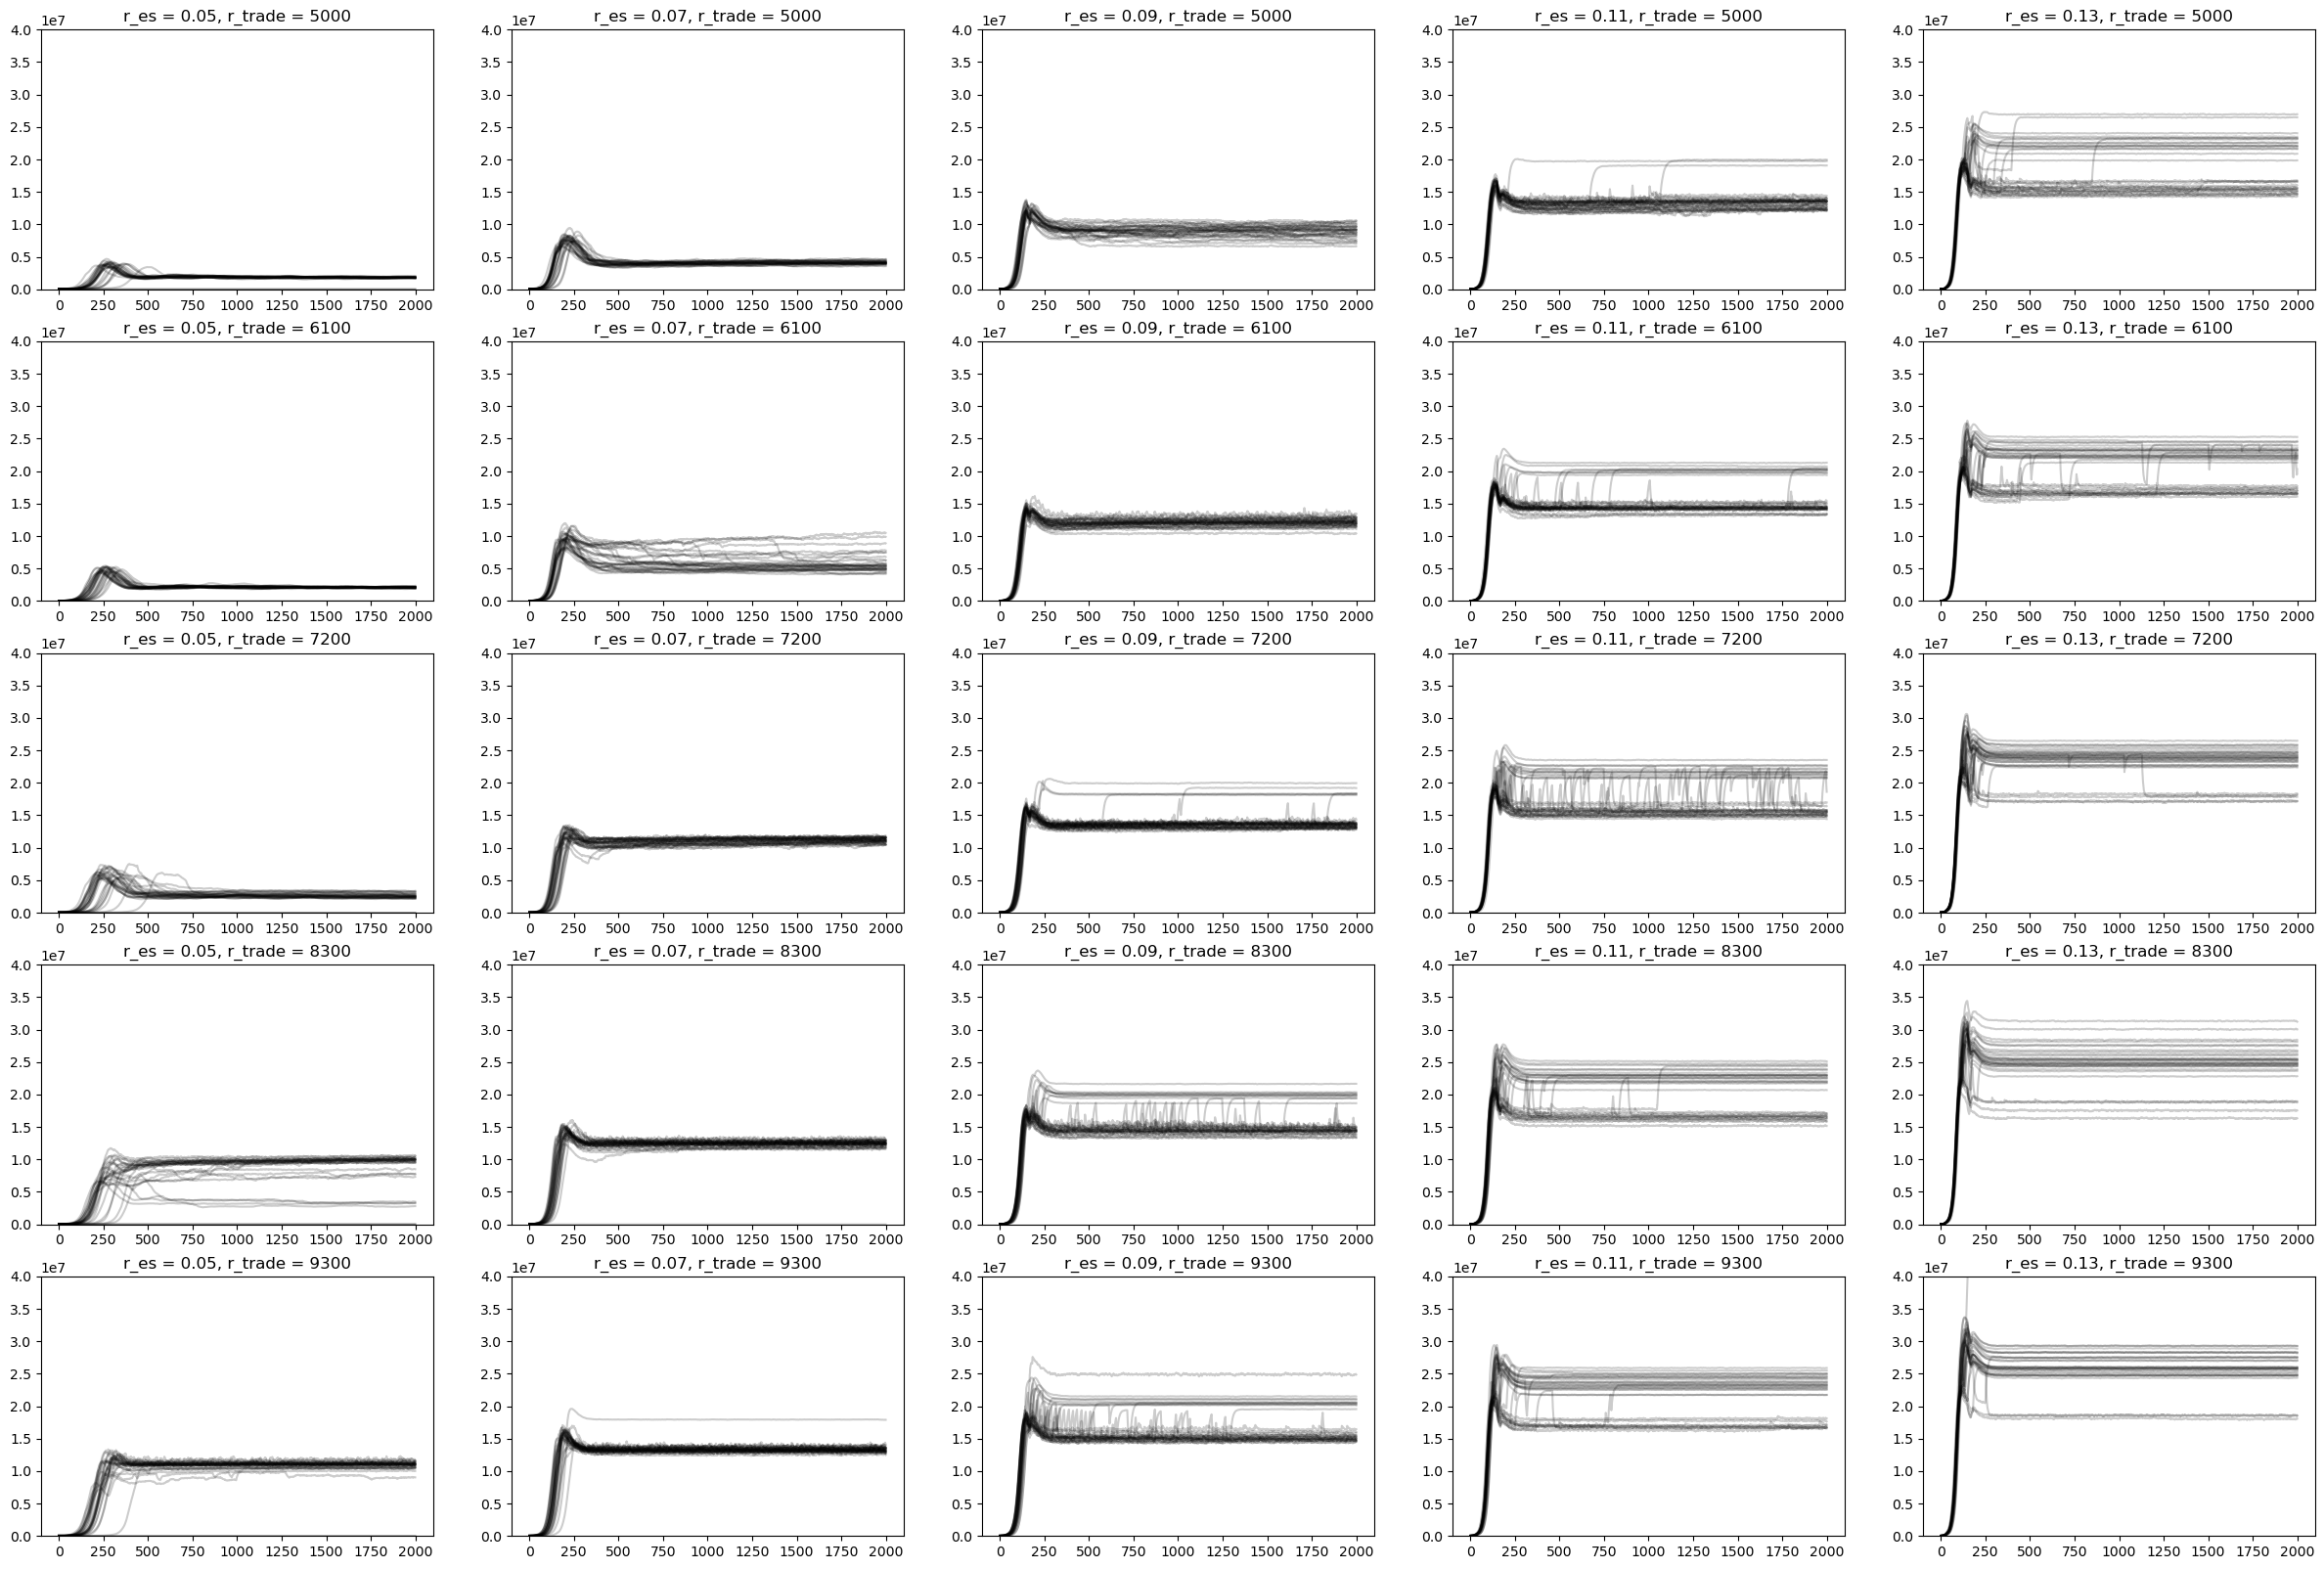

In [12]:
fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess))
fig.set_figwidth(6*len(r_ess))
fig.set_figheight(4*len(r_trades))

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    runs = df.loc[(r_trade, r_es)].unstack('run_id').plot(ax=ax[j,i], legend=False, color='black', alpha=.2)
    ax[j,i].set_title(f'r_es = {r_es}, r_trade = {r_trade}')
    ax[j,i].set_xlabel(None)
    ax[j,i].set_ylim(0, 4e7)
    #ax[j,i].set_yscale('log')

_comment_

### permutation entropy

too large to select full file, need to specify subset

In [5]:
r_trades = np.arange(5000, 9400, 100).tolist()
r_ess = np.arange(0.05, 0.16, 0.005).round(decimals=4).tolist()

# load data
path = '/p/tmp/fritzku/MayaSim/output/x11_dynamical_regimes/results/all_trjs.hd5'

with pd.HDFStore(path) as store:
    data = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess} & step>500', columns=['total_population'])
data.index = data.index.droplevel('test')

In [6]:
# generate empty dataframe with same index (minus 'steps')
index = data.index
entropy = pd.DataFrame(index=index, columns=['e'], dtype='float').groupby(level=(0,1,2)).sum()

In [7]:
# calculate permutation entropy for trajectories for t>500 (after initial overshoot)
from pyunicorn.timeseries import RecurrencePlot

for ind, row in entropy.iterrows():
    # load time series
    dft = data.loc[ind]
    # calculate permutation entropy
    e = RecurrencePlot(dft.values[:,0], dim=3, tau=1, skip_recurrence=True).permutation_entropy()
    # and save.
    entropy.loc[ind, 'e'] = e


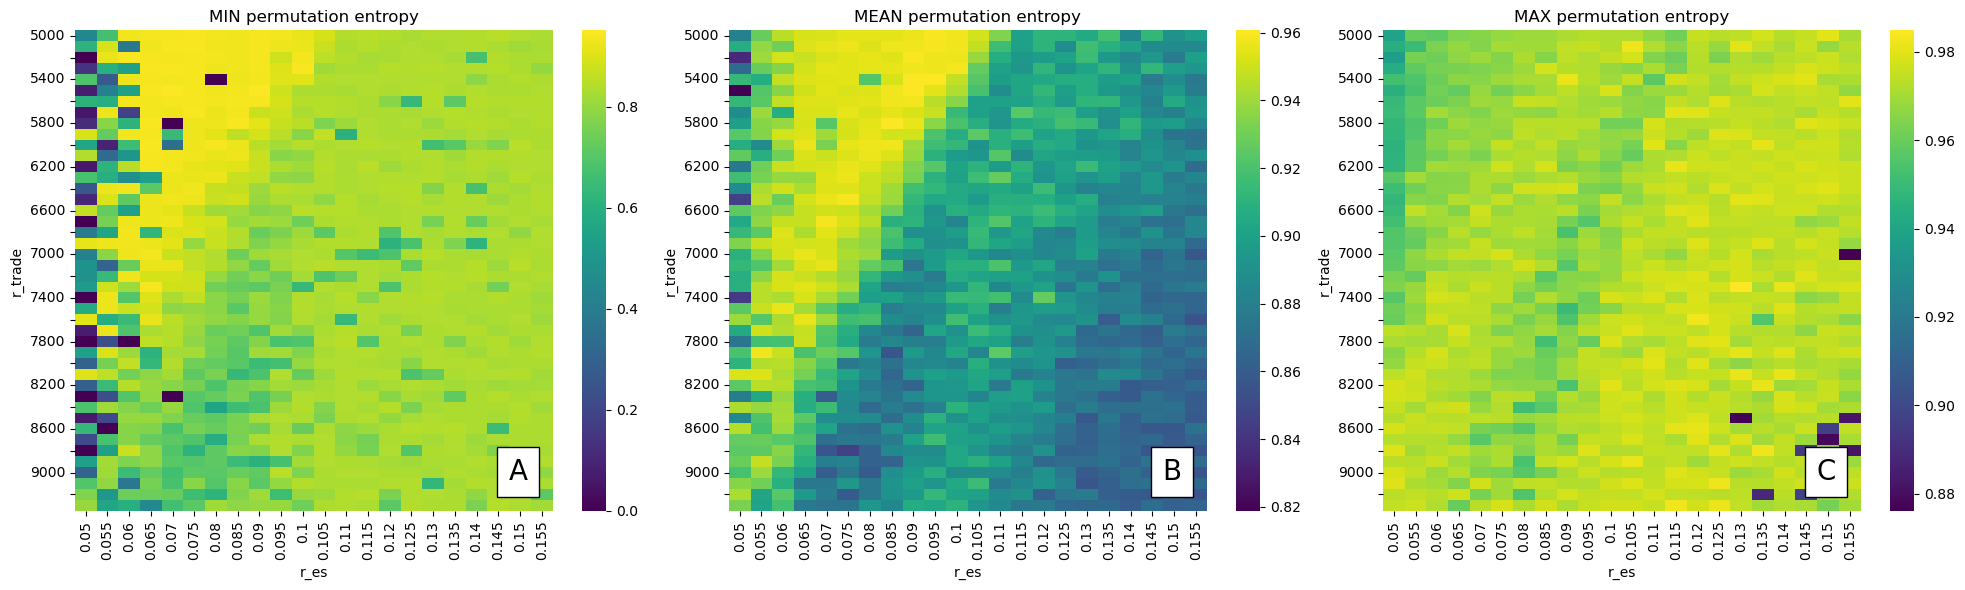

In [8]:
# plot heatmaps of permutation entropy for different values of r_es and r_trade
tmp = entropy
# create annotations
ann = pd.DataFrame(index=entropy.index, columns=['ann'], data=' ').groupby(level=(0, 1)).sum()

fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(20)
fig.set_figheight(6)

results = tmp.groupby(level=[0,1]).min()
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[0], annot=ann.unstack('r_es'))
ax[0].set_title('MIN permutation entropy')

results = tmp.groupby(level=[0,1]).mean()
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[1], annot=ann.unstack('r_es'))
ax[1].set_title('MEAN permutation entropy')

results = tmp.groupby(level=[0,1]).max()
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[2], annot=ann.unstack('r_es'))
ax[2].set_title('MAX permutation entropy')

# results = tmp.groupby(level=[0,1]).max() - tmp.groupby(level=[0,1]).min()
# sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[2], annot=ann.unstack('r_es'))
# ax[2].set_title('MAX difference in permutation entropy')

def add_at(ax, t, loc=2):
    from matplotlib.offsetbox import AnchoredText
    fp = dict(size=20)
    _at = AnchoredText(t, loc=loc, prop=fp)
    ax.add_artist(_at)
    return _at

for x, no in zip(ax, ['A', 'B', 'C']):
    add_at(x, no, loc=4)
    for label in x.get_yaxis().get_ticklabels()[1::2]:
        label.set_visible(False)

fig.set_tight_layout(True)
#fig.savefig('permutation_entropy.pdf')
#fig.savefig('permutation entropy.png')

- expand range to confirm there is no oscillatory regime:

# run 02

SETTING|VALUE
-|-
jobid |
parameter combinations | 36 x 36
samples | 32
tasks | 41472
nodes | 4
tasks-per-node | 16
array-jobs | 324
computation time per job | h ~ 04:40:00  
`precip_modulation` | `False`

total computation time

In [64]:
r_trades = np.arange(4000, 11200, 200).tolist()
r_ess = np.arange(0.005, 0.185, 0.005).round(decimals=3).tolist()